<a href="https://colab.research.google.com/github/AryanJadhao/Vision-Transformer/blob/main/Skin_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

##Import Dataset

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aryanjadhao","key":"9855d06567ee3bc74ed31be144b6a060"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d pacificrm/skindiseasedataset --force

Dataset URL: https://www.kaggle.com/datasets/pacificrm/skindiseasedataset
License(s): CC0-1.0
 95% 1.29G/1.36G [00:12<00:01, 41.5MB/s]
100% 1.36G/1.36G [00:12<00:00, 113MB/s] 


In [7]:
!unzip skindiseasedataset.zip -d skindiseases2

Streaming output truncated to the last 5000 lines.
  inflating: skindiseases2/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/phototoxic-reactions-lime-juice-2.jpeg  
  inflating: skindiseases2/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/phototoxic-reactions-lime-juice-3.jpeg  
  inflating: skindiseases2/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-1.jpeg  
  inflating: skindiseases2/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-10.jpeg  
  inflating: skindiseases2/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-100.jpeg  
  inflating: skindiseases2/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-101.jpeg  
  inflating: skindiseases2/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-102.jpeg  
  inflating: skindiseases2/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damaged-skin-103.jpeg  
  inflating: skindiseases2/SkinDisease/SkinDisease/train/Sun_Sunlight_Damage/sun-damag

In [8]:
train_path = "/content/skindiseases2/SkinDisease/SkinDisease/train"
test_path = "/content/skindiseases2/SkinDisease/SkinDisease/test"

In [9]:
train_dataset = datasets.ImageFolder(train_path)

In [10]:
import collections

# Get the class names and their corresponding integer labels
class_names = train_dataset.classes
targets = train_dataset.targets

# Count the occurrences of each target (label)
target_counts = collections.Counter(targets)

# Create a dictionary mapping class names to their counts
class_distribution = {class_names[label]: count for label, count in sorted(target_counts.items())}

print("Class Distribution:")
total_count = 0
for class_name, count in class_distribution.items():
    print(f"{class_name}: {count}")
    total_count += count

Class Distribution:
Acne: 593
Actinic_Keratosis: 748
Benign_tumors: 1093
Bullous: 504
Candidiasis: 248
DrugEruption: 547
Eczema: 1010
Infestations_Bites: 524
Lichen: 553
Lupus: 311
Moles: 361
Psoriasis: 820
Rosacea: 254
Seborrh_Keratoses: 455
SkinCancer: 693
Sun_Sunlight_Damage: 312
Tinea: 923
Unknown_Normal: 1651
Vascular_Tumors: 543
Vasculitis: 461
Vitiligo: 714
Warts: 580


##Resize to (256,256)

In [11]:
from PIL import Image
import os

root = train_path   # your train folder path

for cls in os.listdir(root):
    cls_path = os.path.join(root, cls)
    if not os.path.isdir(cls_path):
        continue

    for img in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img)
        try:
            im = Image.open(img_path).convert("RGB")
            im = im.resize((256, 256))
            im.save(img_path)
        except:
            pass


In [12]:
root = test_path   # your test folder path

for cls in os.listdir(root):
    cls_path = os.path.join(root, cls)
    if not os.path.isdir(cls_path):
        continue

    for img in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img)
        try:
            im = Image.open(img_path).convert("RGB")
            im = im.resize((256, 256))
            im.save(img_path)
        except:
            pass


##HyperParameters

In [13]:
num_classes = 22
num_channels = 3
img_size = 224
patch_size = 16
num_patches = (img_size // patch_size) ** 2
embedding_dim = 256
num_heads = 8
num_layers = 8
mlp_dim = 256

##Data Augmentation

In [14]:
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    # transforms.ColorJitter(0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3,
                          std=[0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3,
                          std=[0.5]*3)
])

In [15]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

In [16]:
classes = train_dataset.classes
print(classes)

['Acne', 'Actinic_Keratosis', 'Benign_tumors', 'Bullous', 'Candidiasis', 'DrugEruption', 'Eczema', 'Infestations_Bites', 'Lichen', 'Lupus', 'Moles', 'Psoriasis', 'Rosacea', 'Seborrh_Keratoses', 'SkinCancer', 'Sun_Sunlight_Damage', 'Tinea', 'Unknown_Normal', 'Vascular_Tumors', 'Vasculitis', 'Vitiligo', 'Warts']


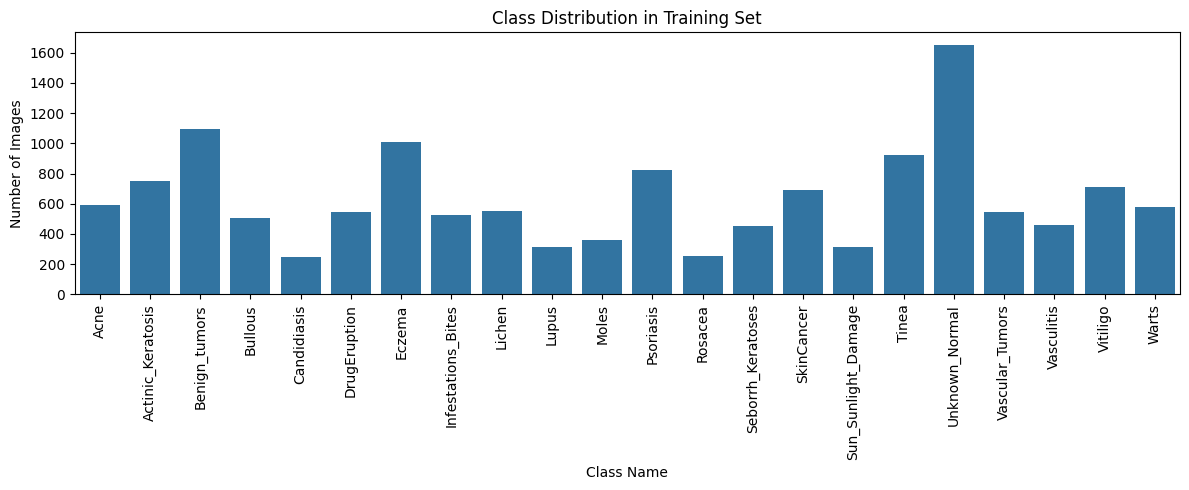

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# 1. Class distribution bar chart
label_counts = Counter(train_dataset.targets)
plt.figure(figsize=(12, 5))
sns.barplot(x=[class_names[i] for i in label_counts.keys()], y=list(label_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xlabel("Class Name")
plt.tight_layout()
plt.show()

##Visual Images

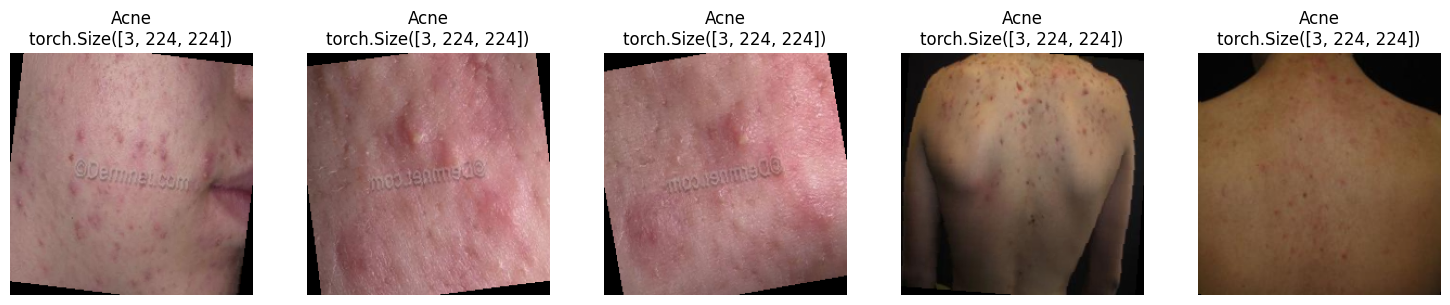

In [28]:
def visualize_samples(dataset, n=5):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        image, label = dataset[i]
        img_display = image.permute(1, 2, 0).numpy() * 0.5 + 0.5
        axes[i].imshow(img_display)
        axes[i].set_title(f"{class_names[label]}\n{image.shape}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

visualize_samples(train_dataset)

In [17]:
batch_size = 32
epochs = 20
learning_rate = 1e-3

In [18]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##Weighted loss to Balance Dataset

In [20]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_dataset.targets
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(labels),
                                     y=np.array(labels))
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"📊 Class weights tensor: {class_weights}")

📊 Class weights tensor: tensor([1.0653, 0.8446, 0.5780, 1.2534, 2.5473, 1.1549, 0.6255, 1.2056, 1.1424,
        2.0313, 1.7499, 0.7704, 2.4871, 1.3884, 0.9116, 2.0248, 0.6844, 0.3826,
        1.1634, 1.3703, 0.8848, 1.0892], device='cuda:0')


In [46]:
import time

start = time.time()
for i, (images, labels) in enumerate(train_loader):
    if i == 32:
        break
end = time.time()

print("32 batches time:", end-start)


32 batches time: 2.8477447032928467


##Pretrained ResNet18

In [47]:
from torchvision.models import resnet18, ResNet18_Weights

In [49]:
weights_resnet = ResNet18_Weights.IMAGENET1K_V1
model_resnet = resnet18(weights=weights_resnet)
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, num_classes)

model_resnet = model_resnet.to(device)

In [50]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=learning_rate)

In [51]:
for epoch in range(epochs):
  model_resnet.train()
  total_loss = 0
  correct = 0
  total_epoch_loss = 0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = model_resnet(images)

    loss = criterion(outputs, labels)
    loss.backward()


    optimizer.step()

    correct += (outputs.argmax(dim=1) == labels).sum().item()
    total_loss += loss.item()
    total_epoch_loss += labels.size(0)

  print(f"Epoch: {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader)}, Accuracy: {100 * correct/total_epoch_loss:.2f}%")

Epoch: 1/20, Loss: 2.571821054370924, Accuracy: 24.05%
Epoch: 2/20, Loss: 2.2266830537511013, Accuracy: 33.00%
Epoch: 3/20, Loss: 2.0163004516185015, Accuracy: 38.62%
Epoch: 4/20, Loss: 1.8726023868582715, Accuracy: 42.91%
Epoch: 5/20, Loss: 1.71928063836591, Accuracy: 46.90%
Epoch: 6/20, Loss: 1.5973799032726508, Accuracy: 50.42%
Epoch: 7/20, Loss: 1.4666327576527651, Accuracy: 53.68%
Epoch: 8/20, Loss: 1.3599626009491668, Accuracy: 57.20%
Epoch: 9/20, Loss: 1.224929500585315, Accuracy: 60.79%
Epoch: 10/20, Loss: 1.1199339458312112, Accuracy: 63.51%
Epoch: 11/20, Loss: 1.003768094791763, Accuracy: 67.45%
Epoch: 12/20, Loss: 0.8862196204306065, Accuracy: 70.58%
Epoch: 13/20, Loss: 0.7873170005179, Accuracy: 73.33%
Epoch: 14/20, Loss: 0.6939371168955989, Accuracy: 76.23%
Epoch: 15/20, Loss: 0.5906355846716069, Accuracy: 79.30%
Epoch: 16/20, Loss: 0.5242501496926121, Accuracy: 82.03%
Epoch: 17/20, Loss: 0.4873830969991355, Accuracy: 82.77%
Epoch: 18/20, Loss: 0.4202186290046264, Accuracy

In [53]:
model_resnet.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model_resnet(images)
    pred = outputs.argmax(dim=1)
    correct += (pred == labels).sum().item()
    total += labels.size(0)

test_accuracy = 100 * correct/total
print(f"Test_Accuracy = {test_accuracy:.2f}%")

Test_Accuracy = 61.77%


##Pretrained EfficientNet